In [7]:
# import os
# import pandas as pd
# from pandas import ExcelWriter
# from pandas import ExcelFile

# import random as rnd
# import matplotlib.pyplot as plt
# from matplotlib.widgets import Button
# from matplotlib.text import Annotation

# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
import plotly.express as px
import seaborn as sns
from IPython.display import HTML, display


# Dependencies for GDP data
from pandas import ExcelWriter
from pandas import ExcelFile

In [11]:
# File to Load for Olympic Data
olympic_csv = "resources/athlete_events.csv"

# Read .csv File and store into Pandas data frame for Olympic Data
olympic_raw = pd.read_csv(olympic_csv)
pd.options.display.float_format = '{:.2f}'.format
olympic_raw.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.00,180.00,80.00,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.00,170.00,60.00,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.00,nan,nan,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.00,nan,nan,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.00,185.00,82.00,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [132]:
# remove all rows of data for Olympics taking place before the end of WW2 (1945).
olympic_raw_post_war = olympic_raw[olympic_raw.Year > 1945]

# summer olympic data, post WW2.
summer_olympics = olympic_raw_post_war[olympic_raw_post_war.Season != "Winter"]
summer_olympics.dtypes

ID          int64
Name       object
Sex        object
Age       float64
Height    float64
Weight    float64
Team       object
NOC        object
Games      object
Year        int64
Season     object
City       object
Sport      object
Event      object
Medal      object
dtype: object

In [36]:
gdp_data = pd.read_excel("Country GDP Final.xls")
gdp_data.head()

,NOC,NOC Region,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,AFG,Afghanistan,nan,nan,4055176933.37,4515563413.83,5226775163.30,6209140044.01,6971286731.72,9747886104.53,...,12439087076.77,15856574731.44,17804280538.11,20001615788.67,20561054090.40,20484873230.21,19907111418.99,19362642266.65,20191764940.16,19362969582.36
1,ALB,Albania,3480355188.60,3922099470.97,4348070165.19,5611492282.87,7184681398.57,8052075642.11,8896073938.31,10677321490.38,...,12044223457.83,11926962834.96,12890867535.56,12319784701.33,12776277648.92,13228244336.32,11386927679.09,11861353752.07,13025064966.58,15102500898.24
2,ALG,Algeria,54786074940.21,54743249368.65,56758113501.17,67866141223.59,85324767230.49,103198442061.08,117030941571.94,134978727825.85,...,137214821177.36,161205065469.31,200015355528.47,209062886917.04,209754763860.68,213808808746.70,165978425168.39,160032930353.76,167390266100.76,173757952824.25
3,AND,Andorra,1434429703.34,1496912751.68,1733116883.12,2398645598.19,2935659299.73,3255789080.96,3543256805.92,4016972351.49,...,3660530702.97,3355695364.24,3442062830.14,3164615186.95,3281585236.33,3350736367.25,2811489408.89,2877311946.90,3013387423.94,3236543909.35
4,ANG,Angola,9129594818.61,8936063723.20,15285594828.42,17812705294.33,23552052407.55,36970918699.25,52381006892.04,65266452081.39,...,70307163678.24,83799496611.20,111789686464.44,128052853643.11,136709862831.19,145712200312.51,116193649124.15,101123851090.46,122123822333.59,105750987618.63


In [158]:
# GDP and medal count analysis on 2016 Olympics
olympics_2016 = summer_olympics.loc[summer_olympics.Year == 2016]

# # Drop rows where Medal is NaN
no_null_olympics_2016 = olympics_2016.dropna(how='any')

# # Dropping duplicate medals for team events
final_result = no_null_olympics_2016.drop_duplicates(subset=['Event', 'NOC', 'Medal'])

# Grouping by NOC countries and calculating total medals won by country
medal_count_by_NOC_2016 = final_result.NOC.value_counts().to_frame(name = "Medal_Count").reset_index()
final_medal_count_by_NOC_2016 = medal_count_by_NOC_2016.rename(columns={"index": "NOC"})

# Creating a dataframe for just 2016 GDP data
gdp_NOC_2016 = gdp_data.loc[: , ["NOC", "2016"]]

# Merge the medal count by NOC and GDP dataframes
merge_2016 = pd.merge(final_medal_count_by_NOC_2016, gdp_NOC_2016, on="NOC", how="left")
merge_2016["Reformatted"] = (merge_2016["2016"]/1000000000).apply(lambda x: "${:,.2f}BB".format(x))
clean_merge_2016 = merge_2016.dropna(how="any")

clean_merge_2016.dtypes

NOC             object
Medal_Count      int64
2016           float64
Reformatted     object
dtype: object

In [159]:
# Attempting to create a function to filter Olympic data by year
column = ['Year']
equal = ['==']
condition = [2016]

def olympic_year_medal_count():
    query = ' & '.join(f'{i} {j} {repr(k)}' for i, j, k in zip(column, equal, condition))
    df = summer_olympics.query(query).dropna(how="any").drop_duplicates(subset=['Event', 'NOC', 'Medal']).NOC.value_counts().to_frame(name = "Medal_Count").reset_index().head()
    gdp_df = gdp_data.loc[: , ["NOC", condition]]
    return 

olympic_year_medal_count()

TypeError: unhashable type: 'list'

The correlation coefficient (rvalue) between 2016 Rio Olympics GDP and total medal count is: 0.866557
The coefficient of determination (r-squared) value is: 0.750921
 


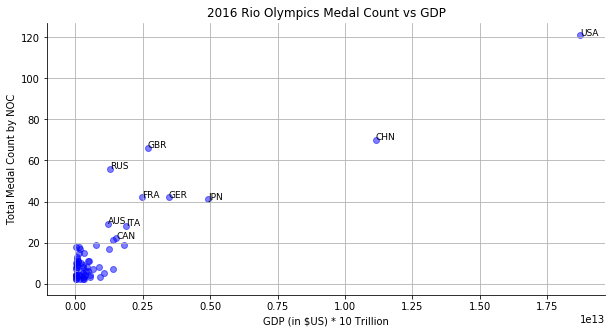

In [130]:
# Manipulate data
olympic_year = "2016 Rio Olympics"
medal_count = clean_merge_2016["Medal_Count"]
gdp = clean_merge_2016["2016"]
label = clean_merge_2016["NOC"]
x_values = gdp
y_values = medal_count

# Function Calculating regression 
def regression(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values , y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    r_squared = (rvalue**2)
       
    print(f"The correlation coefficient (rvalue) between {olympic_year} GDP and total medal count is: {round(rvalue, 6)}")
    print(f"The coefficient of determination (r-squared) value is: {round(r_squared, 6)}")

regression(x_values, y_values)


# Scatterplot Function
def scatterplot (df, x_values, y_values):
    try:
        x=x_values
        y=y_values
    
        fig, ax = plt.subplots(figsize=(10,5))
        colors = "blue"
    
        for i in range(len(df)):
            ax.scatter(x[i], y[i], color = colors, alpha=0.5)     
        
    except (KeyError):
        print(" ")
        
    try:
        limit = 10
        for i, type in enumerate(label):
            if i>= limit: 
                break
            else:
                x=x_values[i]
                y=y_values[i]
                plt.text(x, y, s=type, fontsize=9)
            
    except (KeyError):
        print(" ")
        
    ax.set_title(f"{olympic_year} Medal Count vs GDP")
    ax.set_xlabel("GDP (in $US) * 10 Trillion")
    ax.set_ylabel("Total Medal Count by NOC")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid()
    #plt.plot(x_values, regress_values, "r-")
    plt.show()
    
    
        
scatterplot(clean_merge_2016, x_values, y_values)